In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import setup_plotting_env, clean_ticks, savefig
from rl_analysis.io.df import dlight_exclude_toml
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd

## Load in example dLight processed data

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [5]:
use_dct = dlight_exclude_toml(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.toml"),
    **analysis_config["dlight_common"]
)

In [6]:
dlight_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("uuid", "in", list(use_dct.keys()))],
).sort_index()

In [7]:
dlight_df["uuid"] = dlight_df["uuid"].astype("str")
dlight_df["mouse_id"] = dlight_df["mouse_id"].astype("str")

In [8]:
dlight_df = dlight_df.loc[~dlight_df["session_number"].isin([1, 2, 3, 4])].copy()

In [9]:
uuids = dlight_df["uuid"].unique()

In [10]:
setup_plotting_env()

In [11]:
dlight_df["signal_dff"] *= 1e2
dlight_df["reference_dff_fit"] *= 1e2

In [12]:
timestamp_range = (65, 80)

In [15]:
use_uuid = "bba09920-2c6a-4e55-a212-6bf73c6c7167"

In [16]:
segment = dlight_df.loc[
    (dlight_df["uuid"] == use_uuid) & dlight_df["timestamp"].between(*timestamp_range)
]

In [17]:
rng = np.random.default_rng(seed=42)
syllable_cmap = plt.matplotlib.colors.ListedColormap(rng.random(size=(256, 3)))

/tmp/ipykernel_1439461/2844721115.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dlight_df.loc[


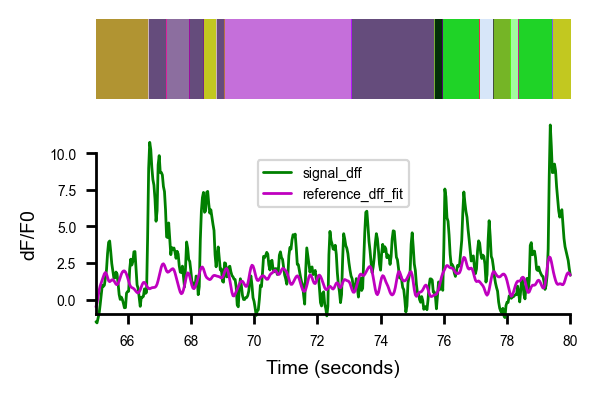

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(3, 2), gridspec_kw={"height_ratios": [1, 2]})
ax[0].imshow(
    dlight_df.loc[
        (dlight_df["uuid"] == use_uuid)
        & dlight_df["timestamp"].between(*timestamp_range)
    ]["predicted_syllable (offline)"][None, :],
    aspect="auto",
    cmap=syllable_cmap,
)
ax[0].axis("off")
dlight_df.loc[
    (dlight_df["uuid"] == use_uuid) & dlight_df["timestamp"].between(*timestamp_range)
].plot(x="timestamp", y="signal_dff", ax=ax[-1], color="g", clip_on=False)
dlight_df.loc[
    (dlight_df["uuid"] == use_uuid) & dlight_df["timestamp"].between(*timestamp_range)
].plot(x="timestamp", y="reference_dff_fit", ax=ax[-1], color="m", clip_on=False)
ax[-1].set_xlim(*timestamp_range)
ax[-1].set_ylim(-1, 10)
ax[-1].set_yticks(np.arange(0, 10.5, 2.5))
ax[-1].set_ylabel("dF/F0")
ax[-1].set_xlabel("Time (seconds)")
sns.despine()
fig.tight_layout()
# savefig(fig, os.path.join(figure_cfg["store_dir"], "dlight_reference_fit_example"), bbox_inches="tight")

In [19]:
_tmp = (
    dlight_df.groupby("uuid")[["reference_dff_fit", "signal_dff"]]
    .corr()["signal_dff"]
    .iloc[::2]
)
_tmp_reref = (
    dlight_df.groupby("uuid")[["reference_dff_fit", "signal_reref_dff"]]
    .corr()["signal_reref_dff"]
    .iloc[::2]
)

In [20]:
setup_plotting_env()

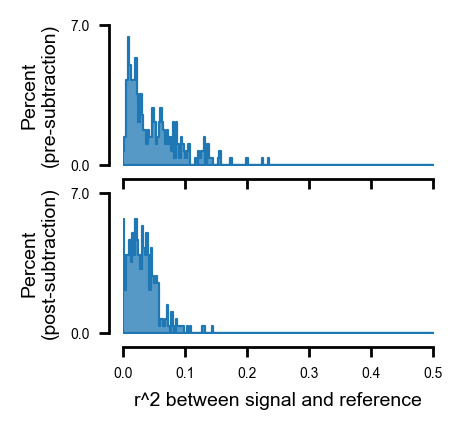

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
sns.histplot(
    _tmp.values**2,
    ax=ax[0],
    bins=np.linspace(0, 0.5, 200),
    stat="percent",
    element="step",
)
sns.histplot(
    _tmp_reref.values**2,
    ax=ax[1],
    bins=np.linspace(0, 0.5, 200),
    stat="percent",
    element="step",
)
plt.xlim(0, 0.5)
ax[0].set_ylabel("Percent\n(pre-subtraction)")
ax[1].set_ylabel("Percent\n(post-subtraction)")
ax[1].set_xlabel("r^2 between signal and reference")
sns.despine(offset=5)
clean_ticks(ax, "y", precision=0)
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "dlight_reference_fit_rsquared"),
    bbox_inches="tight",
)